In [1]:
import numpy as np
from collections import OrderedDict
import best.rss18_functions as rf

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 30
prob['rov_x0'] = np.array([-4.5, -.5])
prob['cop_x0'] = np.array([-4.5, -1.5, 2])
prob['cop_xT'] = np.array([-4.5, -1.5, 2])
prob['cop_sight'] = 2
prob['weak_accu'] = 0.85
prob['prob_margin'] = 0.1
prob['formula'] = '! fail U sampleA'

regs = OrderedDict()

p1 = rf.vertex_to_poly(np.array([[1.2, 0], [2.2, 1], [-1.6, 3.6], [-2.6, 2.6]]))
regs['r1'] = (p1, 1, 'red')
p2 = rf.vertex_to_poly(np.array([[-3, 4], [-3, 5], [-5, 5], [-5, 4]]))
regs['r2'] = (p2, 1, 'red')
p3 = rf.vertex_to_poly(np.array([[2, -1.5], [3, -1], [5, -3], [5, -5], [4, -5]]))
regs['r3'] = (p3, 1, 'red')
p4 = rf.vertex_to_poly(np.array([[1.2, 0], [2.2, 1], [2, -1.5], [3, -1]]))
regs['r4'] = (p4, 0.4, 'orange')
p5 = rf.vertex_to_poly(np.array([[2, -1.5], [2.5, -2.5], [1, -5], [-1, -5]]))
regs['r5'] = (p5, 0.3, 'orange')

a1 = rf.vertex_to_poly(np.array([[4, -2], [5, -2], [5, -1], [4, -1]]))
regs['a1'] = (a1, 0.5, 'blue')
a2 = rf.vertex_to_poly(np.array([[2, -4], [3, -4], [3, -5], [2, -5]]))
regs['a2'] = (a2, 0.5, 'blue')
a3 = rf.vertex_to_poly(np.array([[-2, 0], [-2, 1], [-1, 1], [-1, 0]]))
regs['a3'] = (a3, 0.9, 'blue')

prob['regs'] = regs
prob['env_Nlist'] = [1 if  reg[1] in [0,1] else 5 for reg in regs.itervalues()]
prob['env_x0'] = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]

In [2]:
# plot regions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from best.abstraction import Abstraction

rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10])

image = mpimg.imread("surface.jpg")

fig = plt.figure(figsize=(6, 6))
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)
ax.axis('off')

ax.imshow(image, extent=[-5, 5, -5, 5])

for name, info in regs.iteritems():
    rf.plot_region(ax, info[0], name, info[1], info[2], alpha=0.3)

ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('exp1-workspace.pdf', bbox_inches='tight')

In [3]:
from best.mdp import ParallelMDP

# rover model
rover = rover_abstr.abstract()
rover.input_name = 'ar'
rover.output_name = 'xr'
print rover

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])
copter = copter_abstr.abstract()
copter.input_name = 'ac'
copter.output_name = 'xc'
print copter

# Environment belief model
env = ParallelMDP([rf.environment_belief_model(info[1], [1-prob['weak_accu'], prob['weak_accu']], name) for (name, info) in regs.iteritems()])

# connect rover-env
rover_env_mdp = rover.product(env, connection=rf.get_conn_rov_env(prob['regs']) )
print rover_env_mdp

# Connect copter-env
mdp_copt_env = copter.product(env, connection=rf.get_conn_copt_env(prob['regs'], prob['cop_sight']) )
print mdp_copt_env

print 'MDP totals: {}, {}'.format(rover_env_mdp.N * 3 ,mdp_copt_env.N)

MDP: 5 inputs "ar" --> 100 outputs "xr"
MDP: 7 inputs "ac" --> 200 outputs "xc"
MDP: 5 inputs "ar" --> 312500 outputs "(xr, (r1_b, r2_b, r3_b, r4_b, r5_b, a1_b, a2_b, a3_b))"
MDP: 7 inputs "ac" --> 625000 outputs "(xc, (r1_b, r2_b, r3_b, r4_b, r5_b, a1_b, a2_b, a3_b))"
MDP totals: 937500, 625000


In [4]:
# solve rover LTL problem
from best.ltl import solve_ltl_cosafe

rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, prob['formula'], rf.get_ltl_connection(regs),
                                horizon=prob['rov_T'], verbose=True, delta=0.0001)

# copter problem

# set up target set
init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init
v_max = np.max(rover_ltlpol.val[0].flatten())

idx = np.logical_or(rover_ltlpol.val[0][init_rov, :, init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.val[0][init_rov, :, init_dfsa] < prob['prob_margin'])

Vacc = np.zeros(mdp_copt_env.N_list)
Vacc[:, idx] = 1

end_cop = copter_abstr.x_to_s(prob['cop_xT'])

# constraint set (landing)
Vcon = np.zeros(mdp_copt_env.N_list)
Vcon[end_cop, :] = 1

val_copt_list, pol_copt_list = mdp_copt_env.solve_reach_constrained(Vacc, Vcon, 0.95, horizon=prob['cop_T'], verbose=True)

iteration 0, time 0.00607919692993
iteration 1, time 2.89088916779
iteration 2, time 4.88710808754
iteration 3, time 6.78449702263
iteration 4, time 8.68968200684
iteration 5, time 10.5873661041
iteration 6, time 12.481041193
iteration 7, time 14.3982400894
iteration 8, time 16.2949612141
iteration 9, time 18.1890480518
iteration 10, time 20.0904331207
iteration 11, time 21.9898061752
iteration 12, time 23.8907101154
iteration 13, time 25.795222044
iteration 14, time 27.6836321354
finished after 29.5753819942s and 15 iterations
iteration 0, time 1.19209289551e-06
iteration 1, time 2.05288815498
iteration 2, time 4.07204914093
iteration 3, time 6.12390613556
iteration 4, time 8.16985821724
iteration 5, time 10.2279109955
iteration 6, time 12.2608551979
iteration 7, time 14.3100321293
iteration 8, time 16.5693511963
iteration 9, time 18.7315070629
iteration 10, time 20.8353900909
iteration 11, time 23.0657150745
iteration 12, time 25.1752641201
iteration 13, time 27.398922205
iteration 1

In [5]:
# save controllers
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

if False:
    import cPickle as pickle
    with open('mars.pickle', 'wb') as fp:
      pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.943520724773


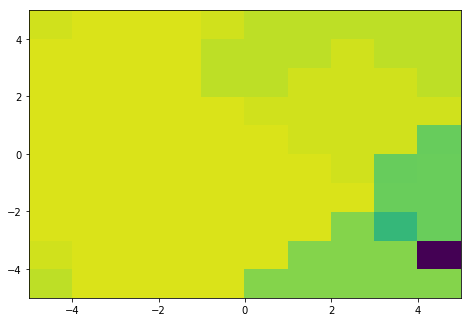

In [6]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    s_map = env.global_state(mapstate)

    _, val = rover_ltlpol((s_abstr, s_map))
    rover_ltlpol.reset()
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0']))

success value: 1.00000011921


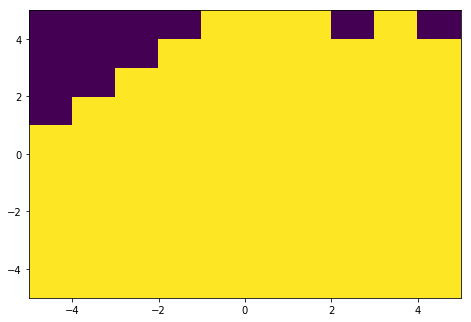

In [7]:
# plot copter value fcn
map_local = prob['env_x0'][:]
map_local[7] = 0

map_init = env.global_state(map_local)

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    return val_copt_list[0][scop, mapstate]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(prob['cop_x0'], map_init))

execution ends at t=3.2
exploration ends at t=24.6
execution ends at t=31.3
execution ends at t=3.2
exploration ends at t=23.4
execution ends at t=23.4


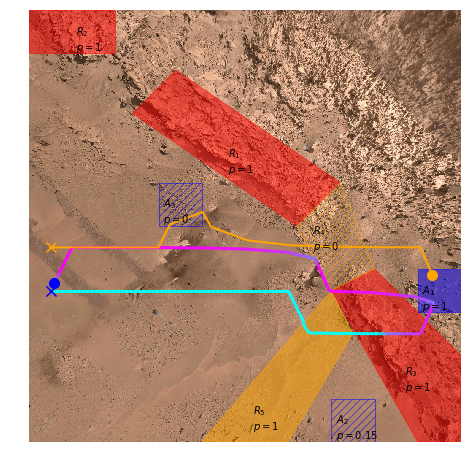

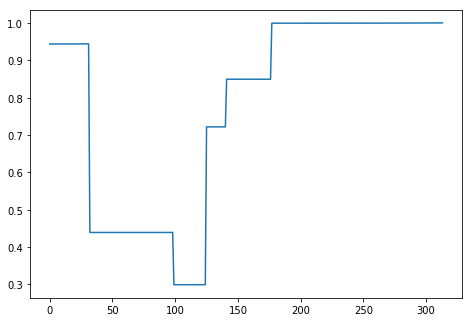

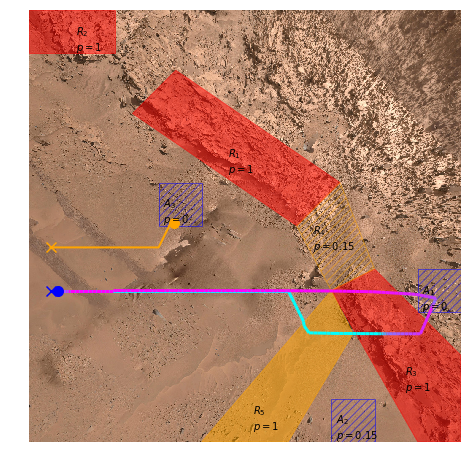

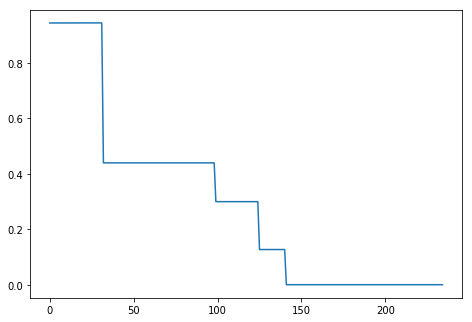

In [8]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from best import midx_to_idx

conn_copt_env = rf.get_conn_copt_env(prob['regs'], prob['cop_sight'])
conn_rov_env = rf.get_conn_rov_env(prob['regs'])
conn_ltl = rf.get_ltl_connection(prob['regs'])

realmaps = [[0, 0, 0, 0, 4, 4, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0]]

for iter in range(len(realmaps)):

    realmap = realmaps[iter]
    mapstate = prob['env_x0'][:]
    rover_policy.reset()
    copter_policy.reset()

    x_rover = prob['rov_x0'].reshape((1,2))
    x_copter = prob['cop_x0'].reshape((1,3))
    val = rover_policy.get_value(x_rover[-1,:].flatten(), midx_to_idx(mapstate, prob['env_Nlist']))

    psuccess = np.array([val])
    tvec = np.array([0])

    # rover execution
    while val > 0.85 and not rover_policy.finished():
        x_curr = x_rover[-1, :].flatten()
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        aps = conn_ltl((x_curr, env.output(x_map)))
        x_next, val = rover_policy(x_curr, x_map, list(aps)[0])

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
            
        x_rover = np.vstack([x_rover, x_del])
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print 'execution ends at t={}'.format(tvec[-1])

    # send out copter
    while not copter_policy.finished():
        x_curr = x_copter[-1, :].flatten()
        map_meas = list(conn_copt_env(x_curr))[0]
        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]
        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        x_next, val = copter_policy(x_curr, x_map)

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
            x_copter = np.vstack([x_copter, x_del])
        else:
            x_copter = np.vstack([x_copter, x_curr])
        
        val = rover_policy.get_value(x_rover[-1,:].flatten(), x_map)
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print 'exploration ends at t={}'.format(tvec[-1])

    mid_probs = env.output(env.global_state(mapstate[:]))

    # rover execution again
    while val > 0.85 and not rover_policy.finished():
        x_curr = x_rover[-1, :].flatten()
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]

        x_map = midx_to_idx(mapstate, prob['env_Nlist'])
        aps = conn_ltl((x_curr, env.output(x_map)))
        x_next, val = rover_policy(x_curr, x_map, list(aps)[0])

        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print 'execution ends at t={}'.format(tvec[-1])

    fig = plt.figure(figsize=(6, 6))
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.axis('off')
    image = mpimg.imread("surface.jpg")
    ax.imshow(image, extent=[-5, 5, -5, 5])

    i = 0
    for (name, info) in prob['regs'].iteritems():
        if realmap[i] == 0 and info[1] != 1:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, mid_probs[i], info[2], hatch=hatch, fill=fill)
        i += 1

    points = np.array([x_copter[:,0], x_copter[:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'))
    lc.set_array(x_copter[:, 2])
    lc.set_linewidth(3)
    ax.add_collection(lc)

    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)
    
    fig.savefig('exp1-{}-trajectory.pdf'.format(iter), bbox_inches='tight')
    
    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.plot(psuccess)

    np.savetxt('exp1-{}-proba.txt'.format(iter),  np.vstack([psuccess, tvec]).T, delimiter=' ')